### Three year summary Lake Geneva

#### Notebook 2

__Purpose:__ Present an analysis method for survey results from beach litter inventories on Lake Geneva.

__Background:__ This is in the context of the global movement to reduce plastic debris in the maritime environment. Riverine inputs are major contributors of plastic debris (and all types of refuse) to the oceans. This is an analysis of the data collected on the shores of Lake Geneva over a three year period. The maritime protocol was modified in very specific ways to adjust for the local geography and population density.

#### Research question: Is this a representative sample ?

##### from notebook one we can assume the following:

1. The data was collected at different locations
2. The data was collected by different groups of people
3. For each year there is one group that collected 50% or more of the samples


If sampling all the trash is not possibile, what if we sample as much as possible and see what that looks like? The following questions could be answered:

1. What does the distribution of survey results look like?
2. Do different groups of people produce different survey results?
3. How different are the survey results from one location to another?
4. What are the most abundant objects?
5. How different are the survey results year over year?

#### From Notebook 1 IMPORTANT!

_In notebook one the conclusion was that the data has different geographic centers and those centers reflect different land use patterns._

_The data is now local so it is allways best to run notebook one first_

_This notebook and all subsequent use the directory establsihed in notebook one (see above)_



In [1]:
# import numpy as np
import json
import csv
import datetime
import collections
# import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import colors as mcolors
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from Utilities.utility_functions import *

In [2]:
# The data is off of the API at https://mwshovel.pythonanywhere.com/dirt/api_home.html 
# You will have the opportunity to save the data locally
# get some file structures in place

# Required variables:
folders = ["Data", "Charts", "Utilities"]
here = os.getcwd()

# check for existing and if not make folders
check_for_folders(folders, here)

# make a dictionary to call path by directory name
my_folders = make_folders(folders, here)

Directory already in place


#### Read in the json data

In [3]:
# Read the JSON data in from local
# there is no need to hit the server a million times

# required variables
the_jsons = [
    '/home/mw-shovel/three_year_final/Data/beach_info.json',
    '/home/mw-shovel/three_year_final/Data/all_data.json'
]

idx = pd.IndexSlice
# all the survey results by code, location, date, project:
my_survey_results = jsonFileGet(the_jsons[1])
def changeProjectName(aList, otherList, projectName):
    aNewList = []   
    for eachDict in aList:       
        if eachDict["location_id"] in otherList:
            eachDict['project_id'] = projectName
            aNewList.append(eachDict)
        else:
            aNewList.append(eachDict)
    return aNewList
            
location_list = ["Plage-de-St-Sulpice", "Parc-des-Pierrettes",  "Tiger-duck-beach", "Saint-Sulpice"]
project_name = "EPFL"
my_survey_resultsx = changeProjectName(my_survey_results, location_list, project_name)

# all the location information:
beach_info = jsonFileGet(the_jsons[0])

# make a data frame:
the_survey_results = pd.DataFrame(my_survey_resultsx)    

#### Make pcs/m, make grouping levels

In [4]:
# making a pcs/m column:

the_survey_results["pcs_m"] = the_survey_results["quantity"]/the_survey_results["length"]

# making a month, day and year column from a datetime object
# makes sorting easier
the_survey_results["py_date"] = pd.to_datetime(the_survey_results["date"])
the_survey_results["py_month"] = the_survey_results["py_date"].dt.month
the_survey_results["py_year"] = the_survey_results["py_date"].dt.year
the_survey_results["py_day"] = the_survey_results["py_date"].dt.weekday

In [5]:
#### one df for abundance and one df for density:
abundance = the_survey_results[["project_id", "location_id", "date","py_date", "py_month", "py_year", "code_id", "quantity"]].copy()
density = the_survey_results[["project_id", "location_id", "date","py_date", "py_day","py_month", "py_year", "code_id", "pcs_m"]].copy()  

### Results: Total pieces of trash per meter

#### Cumulative results

Reported as the total number of objects found, the cumulative and year over year results are given in the table below:

| Statistic     | Year one | Year two | Year three | All   |   
|--------------:|:--------:|:--------:|:----------:|:-----:|
| __Samples__   | <span style="color:red">83</span>       |41        |24          | 148   |
| __mean__      | 8.77     |<span style="color:red">9.99</span>      |9.01        | 9.16  |
| __median__    | 4.83     |<span style="color:red">6.84</span>     |4.24        | 5.52  |
| __Std dev__   | 9.92     |8.52      |<span style="color:red">16.14</span>      |10.75  |
| __25\%ile__   | 3.113    |<span style="color:red">4.41</span>     |2.36        | 3.18  |
| __75\%ile__   | 10.405   |<span style="color:red">12.35</span>    |7.79        | 11.24 | 
| __Minimum__   | 0.68   |0.57      |<span style="color:red">0.11 </span>        | 0.11  | 
| __Maximum__   | 50.075   |39.54     |<span style="color:red">77.05 </span>      | 77.05| 
| _MCBP samples_   |<span style="color:red">80</span>  |<span style="color:red">22</span>    |5   | <span style="color:red">107</span>| 
| _SLR samples_   |0  |18    |<span style="color:red">15</span>      | 33|
| _EPFL samples_  |2 |2     |2| 6| 
| _PC samples_  | 0 |0   |2       | 2| 

Year two has the highest average, median and the greatest innerquartile range. The lowest and the highest daily values were reported in year three. In each year there is one group that collected at least 50% of all the samples.

For each year the mean is greater than the median, suggesting a right skewed distribution. The mean and median are clossest at year two.

In [6]:
daily_total_pcs_m = density[["project_id","location_id", "py_date", "pcs_m"]].groupby(["project_id","location_id", "py_date"]).sum()

end_date = datetime.datetime.strptime("2018-11-14", "%Y-%m-%d")
start_date = datetime.datetime.strptime("2015-11-15", "%Y-%m-%d")
daily_total_pcs_m = daily_total_pcs_m.loc[idx[:,:,start_date:end_date],:]

daily_total_stats = daily_total_pcs_m.describe().to_dict()['pcs_m']
project_names = daily_total_pcs_m.index.get_level_values("project_id").unique()

In [7]:
data_all_dict = daily_total_pcs_m.to_dict()['pcs_m']
data_all_list = list(data_all_dict.items())

In [8]:
# required variables
x = [1 for x in data_all_list]
y = [x[1] for x in data_all_list]
# y axis 
y_limit = max(y)
y_max = y_limit + 2

# title and sup title
title_color = "black"
min_date = "Nov-2015"
max_date = "Nov-2018"
n_samples = len(daily_total_pcs_m["pcs_m"].values)
font_styles = {
    'fontsize': 12,
    'fontfamily':'sans-serif',
    'fontweight' : 'normal',
    'verticalalignment': 'baseline',
    'horizontalalignment': 'center'
}
title = "Pieces of trash per meter"
sub_title = 'All samples {} - {}\nLake Geneva, n={}'.format( min_date, max_date, n_samples)
IQR = "IQR of all data"
pad = 15

# legend
b_box = (1,0.9)
frameAlpha=1
frameEdgeColor="black"
loc="best"
# labels

y_label_size = 12
y_label_color = "black"
y_label_padding = 15

# annotate
data_coords = (-0.2, 5.66)
text_coords = (-0.25, 35)
connection_style="arc3, rad=0.3"
# plots
opac=0.5
marker_size = 10
edge_color = "#ffffff"
flierprops = dict(marker='o', markersize=6, markerfacecolor='black')
# storing output
file_prefix = my_folders["Charts"]
file_suffix = [
    '.svg',
    '.png',    
]
file_names="boxPlotAllData"

# category colors
PROJECT_COLORS = [
    "indigo",
    "darkcyan",
    "olive",
    "darkred",
    
]
project_colors = dict(zip(project_names, PROJECT_COLORS))
color = "wheat"
# box plot stuff
sat = 1
l_width = 1


def makeBoxPlots(y,aDf, project_names):   
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = sns.boxplot(y, orient='v', saturation=sat, linewidth=l_width, color= color, flierprops=flierprops)
    for project in project_names:       
        this_y = aDf.loc[project]['pcs_m'].values
        the_count = len(this_y)
        this_x = [1 for x in this_y]
       
        ax = sns.stripplot(x=this_x, y=this_y, jitter=True, label='{}: {}'.format(project, the_count), size=marker_size, color=project_colors[project], linewidth=1,edgecolor=edge_color)
    ax.margins(0.05)  
    ax.set_xticks([])
    ax.annotate(
        IQR,
        xy=data_coords,
        xycoords='data',
        xytext= text_coords ,
        textcoords='data',
        horizontalalignment="center",
        fontsize=12,
        arrowprops=dict(
            arrowstyle="->",
            connectionstyle=connection_style)
        )
    plt.setp(ax.artists, edgecolor = 'k')
    plt.setp(ax.lines, color='k')
    plt.subplots_adjust(top=0.85)
    plt.ylabel('Pieces of trash per meter', labelpad=y_label_padding, color=y_label_color, size=y_label_size)
    plt.yticks(np.arange(0, y_max, step=10))
    plt.xticks([])
    plt.ylim(-1, y_max)
    plt.suptitle(title, fontfamily="sans-serif", fontweight="roman", fontsize=14, x=0.13, ha="left", color=title_color)
    plt.title(sub_title, fontdict=font_styles, pad=pad, x=0, ha="left", color=title_color)
    plt.legend(loc=loc, title="Samples per group", bbox_to_anchor=b_box, framealpha=frameAlpha, edgecolor=frameEdgeColor)
    for x in file_suffix:
        save_me = '{}/{}{}'.format(file_prefix, file_names, x)
        plt.savefig(save_me, bbox_inches="tight")  
    
    plt.show()
    plt.close()  
    
def makeBoxPlot(y,aDf, project_names):   
    makeBoxPlots(y,aDf, project_names)

 

### All data Nov 2015 - Nov 2018: mean, median, count...

In [9]:
daily_total_pcs_m.describe()

,pcs_m
count,148.000000
mean,9.160844
std,10.752655
min,0.117647
25%,3.183535
50%,5.526347
75%,11.240594
max,77.055556


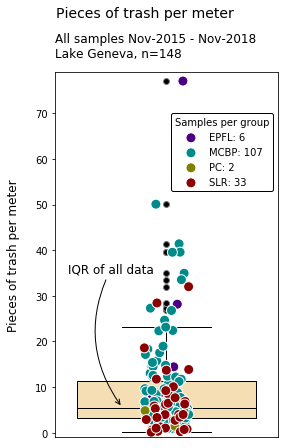

In [10]:
makeBoxPlot(y,daily_total_pcs_m, project_names)  

### Year one: Nov 2015 - Nov 2016

In [11]:
# index of d_t_p_m ["project_id","py_year","location_id", "py_date"]
start_end = convertStringToDate([("2015-11-15", "2016-11-14")])
year_one = daily_total_pcs_m.loc[idx[:,:,start_end[0][0]:start_end[0][1]], :]
project_names = year_one.index.get_level_values("project_id").unique()

In [12]:
year_one_dict = year_one.to_dict()['pcs_m']
year_one_list = list(year_one_dict.items())

In [13]:
# required variables
x = [1 for x in year_one_list]
y = [x[1] for x in year_one_list]
# y axis 
y_limit = max(y)
y_max = y_limit + 2
# title and sup title
title_color = "black"
min_date = "Nov-2015"
max_date = "Nov-2016"
n_samples = len(year_one)
font_styles = {
    'fontsize': 12,
    'fontfamily':'sans-serif',
    'fontweight' : 'normal',
    'verticalalignment': 'baseline',
    'horizontalalignment': 'center'
}
title = "Year one trash per meter"
sub_title = '{} - {}\nLake Geneva, n={}'.format( min_date, max_date, n_samples)
IQR = "IQR year one"
# legend
b_box = (.5,0.93)
loc="upper left"
# labels

y_label_size = 12
y_label_color = "black"
y_label_padding = 15
# annotate
data_coords = (-0.2, 4.832864)
text_coords = (-0.25, 30)
connection_style="arc3, rad=0.3"
# plots
opac=0.5
marker_size = 10
edge_color = "#ffffff"
flierprops = dict(marker='o', markersize=6, markerfacecolor='black')
file_names="boxPlotYearOne"

In [14]:
year_one.describe()

,pcs_m
count,83.000000
mean,8.708838
std,9.882661
min,0.681159
25%,3.149679
50%,4.796875
75%,10.155738
max,50.075000


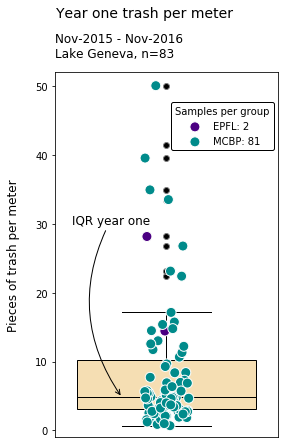

In [15]:
makeBoxPlot(y,year_one, project_names)

### Year two: Nov 2016 - Nov 2017

In [16]:
# index of d_t_p_m ["project_id","py_year","location_id", "py_date"]
start_end = convertStringToDate([("2016-11-15", "2017-11-14")])
year_two = daily_total_pcs_m.loc[idx[:,:,start_end[0][0]:start_end[0][1]], :]
project_names = year_two.index.get_level_values("project_id").unique()

In [17]:
year_two_dict = year_two.to_dict()['pcs_m']
year_two_list = list(year_two_dict.items())

In [18]:
# required variables
x = [1 for x in year_two_list]
y = [x[1] for x in year_two_list]
# y axis 
y_limit = max(y)
y_max = y_limit + 2

# title and sup title
title_color = "black"
min_date = "Nov-2016"
max_date = "Nov-2017"
n_samples = len(year_two)
font_styles = {
    'fontsize': 12,
    'fontfamily':'sans-serif',
    'fontweight' : 'normal',
    'verticalalignment': 'baseline',
    'horizontalalignment': 'center'
}
title = "Year two trash per meter"
sub_title = '{} - {}\nLake Geneva, n={}'.format( min_date, max_date, n_samples)
IQR = "IQR year two"
# legend
b_box = (.5,0.93)
loc="upper left"
# labels
y_label_size = 12
y_label_color = "black"
y_label_padding = 15
# annotate
data_coords = (-0.2, 6.84)
text_coords = (-0.25, 30)
connection_style="arc3, rad=0.3"
# plots
opac=0.5
marker_size = 10
edge_color = "#ffffff"
flierprops = dict(marker='o', markersize=6, markerfacecolor='black')
file_names="boxPlotYearTwo"

In [19]:
year_two.describe()

,pcs_m
count,41.000000
mean,10.158769
std,8.569256
min,0.576471
25%,5.666667
50%,6.857143
75%,12.387097
max,39.540541


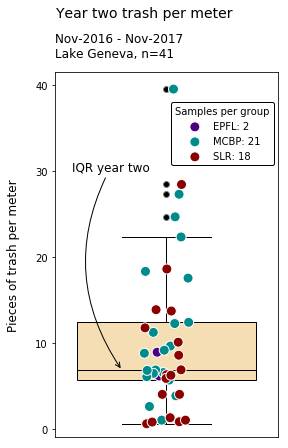

In [20]:
makeBoxPlot(y,year_two, project_names)

### Year three: Nov 2017 - Nov 2018

In [21]:
# index of d_t_p_m ["project_id","py_year","location_id", "py_date"]
start_end = convertStringToDate([("2017-11-15", "2018-11-14")])
year_three = daily_total_pcs_m.loc[idx[:,:,start_end[0][0]:start_end[0][1]], :]
project_names = year_three.index.get_level_values("project_id").unique()

In [22]:
year_three_dict = year_three.to_dict()['pcs_m']
year_three_list = list(year_three_dict.items())

In [23]:
# required variables
x = [1 for x in year_three_list]
y = [x[1] for x in year_three_list]
# y axis 
y_limit = max(y)
y_max = y_limit + 2
# title and sup title
title_color = "black"
min_date = "Nov-2017"
max_date = "Nov-2018"
n_samples = len(year_three)
font_styles = {
    'fontsize': 12,
    'fontfamily':'sans-serif',
    'fontweight' : 'normal',
    'verticalalignment': 'baseline',
    'horizontalalignment': 'center'
}
title = "Year three trash per meter"
sub_title = '{} - {}\nLake Geneva, n={}'.format( min_date, max_date, n_samples)
IQR = "IQR year three"
# legend
b_box = (.25,0.93)
loc="upper left"
# labels
y_label_size = 12
y_label_color = "black"
y_label_padding = 15
# annotate
data_coords = (-0.2, 4.24)
text_coords = (-0.25, 45)
connection_style="arc3, rad=0.3"
# plots
opac=0.5
marker_size = 10
edge_color = "#ffffff"
flierprops = dict(marker='o', markersize=6, markerfacecolor='black')
file_names="boxPlotYearThree"

In [24]:
year_three.describe()

,pcs_m
count,24.000000
mean,9.019244
std,16.140460
min,0.117647
25%,2.366757
50%,4.244992
75%,7.791667
max,77.055556


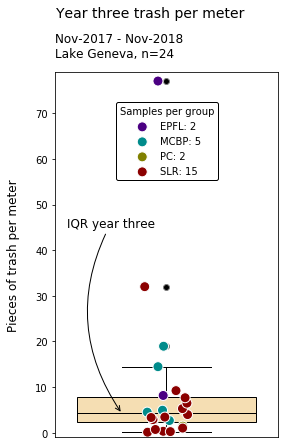

In [25]:
makeBoxPlot(y,year_three, project_names)